In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import shap

import warnings
warnings.filterwarnings("ignore")

c:\Users\mijuu\Documents\insurance_analytics_prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/cleaned_data.csv")

# 🔹 Step 1: Filter data to only those rows with claims > 0
df_claims = df[df['TotalClaims'] > 0].copy()
print(f"🧾 Filtered dataset to {len(df_claims)} records with non-zero claims.")

# 🔹 Step 2: Define Features and Target
target = 'TotalClaims'

# You can adjust this list based on your EDA
features = [
    'TotalPremium', 'SumInsured', 'Province', 'Gender', 'VehicleType',
    'make', 'Model', 'Cylinders', 'kilowatts', 'cubiccapacity', 'PostalCode'
]

# Drop missing values in the selected features and target
df_model = df_claims[features + [target]].dropna()
print(f"📦 Cleaned data: {df_model.shape[0]} rows after dropping NA.")

X = df_model[features]
y = df_model[target]

# 🔹 Step 3: Preprocessing
categorical = X.select_dtypes(include='object').columns.tolist()
numerical = X.select_dtypes(include='number').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

# 🔹 Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"✂️ Split data: {X_train.shape[0]} train / {X_test.shape[0]} test")

# 🔹 Step 5: Train and Evaluate Models
def evaluate(model_name, model):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n📊 {model_name} Evaluation:")
    print(f"   MAE:  {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   R²:   {r2:.4f}")
    
    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

# 🔹 Step 6: Run All Models
results = []

# Linear Regression
results.append(evaluate("Linear Regression", LinearRegression()))

# Random Forest
results.append(evaluate("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42)))

# XGBoost
results.append(evaluate("XGBoost", XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)))

# 🔹 Step 7: Show Summary
results_df = pd.DataFrame(results)
print("\n✅ Summary of All Models:\n")
print(results_df.sort_values(by='R2', ascending=False))

🧾 Filtered dataset to 2788 records with non-zero claims.
📦 Cleaned data: 2788 rows after dropping NA.
✂️ Split data: 2230 train / 558 test

📊 Linear Regression Evaluation:
   MAE:  22527.45
   RMSE: 38683.35
   R²:   0.0695

📊 Random Forest Evaluation:
   MAE:  16444.15
   RMSE: 36406.27
   R²:   0.1759

📊 XGBoost Evaluation:
   MAE:  16428.24
   RMSE: 36511.19
   R²:   0.1711

✅ Summary of All Models:

               Model           MAE          RMSE        R2
1      Random Forest  16444.154639  36406.267352  0.175863
2            XGBoost  16428.236086  36511.194929  0.171106
0  Linear Regression  22527.447020  38683.345260  0.069546


Linear Regression performed poorly, suggesting the relationship between features and claim amount is likely non-linear.

Random Forest is the most reliable overall for predicting claim severity, balancing bias and variance well.

XGBoost is a close contender and may perform better with further tuning.

Feature Importance with Visualization

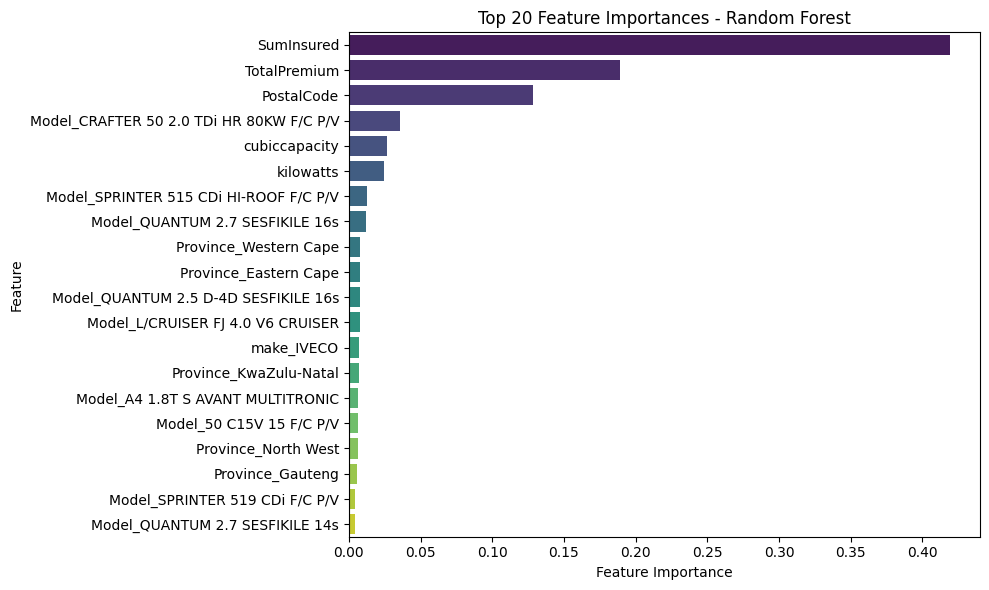

In [3]:
# Refit model on full data (train + test) to analyze full feature importances
X_all = X
y_all = y

# Fit Random Forest with preprocessing pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_all, y_all)

# Get feature names from preprocessor
ohe = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical)
all_feature_names = numerical + cat_feature_names.tolist()

# Extract feature importances
rf_model = rf_pipeline.named_steps['model']
importances = rf_model.feature_importances_

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 🔍 Display top 20 important features
top_n = 20
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(top_n), palette='viridis')
plt.title(f"Top {top_n} Feature Importances - Random Forest")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

SHAP Analysis for random forest

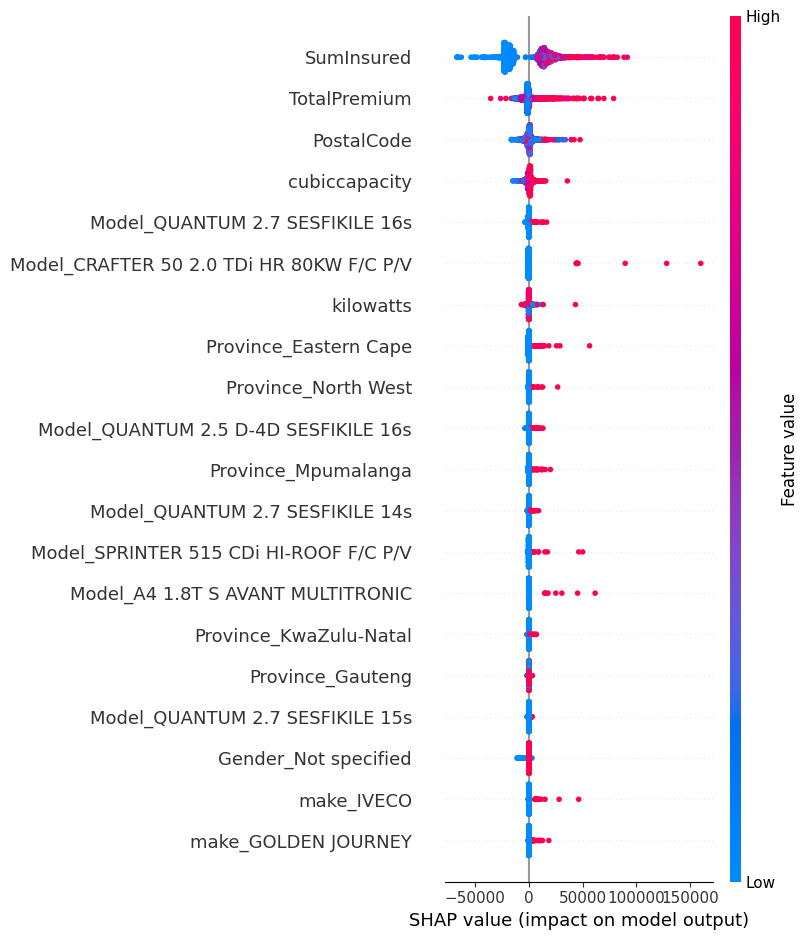

In [4]:
# Refit Random Forest on all data
rf_pipeline.fit(X_all, y_all)
rf_model = rf_pipeline.named_steps['model']

# Transform full feature set
X_transformed = preprocessor.transform(X_all)

# Convert to dense float array if it's sparse
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

# Ensure float type
X_transformed = X_transformed.astype(np.float64)

# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_transformed)

# Get feature names
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical)
all_feature_names = numerical + cat_feature_names.tolist()

# Convert to DataFrame for plotting
X_shap_df = pd.DataFrame(X_transformed, columns=all_feature_names)

# Plot SHAP summary (feature importance)
shap.summary_plot(shap_values, features=X_shap_df, feature_names=all_feature_names)